In [7]:
import pandas as pd
import joblib

clf = joblib.load("rf_area_classifier.pkl")

new_data = pd.read_csv("../2_Feature_Extraction_test_all_data/extract_features/tracking_features.csv")  
X_new = new_data.drop(columns=["tracking_id"])

new_data["predicted_label"] = clf.predict(X_new)
new_data.to_csv("new_tracking_predictions.csv", index=False)



<Axes: title={'center': 'Predicted Label Distribution'}, xlabel='predicted_label'>

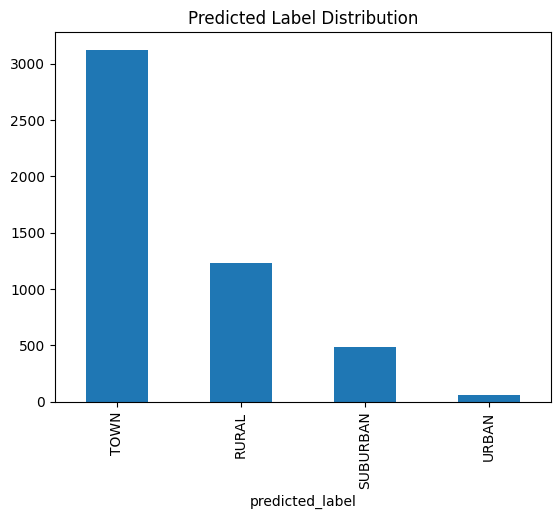

In [8]:
new_data["predicted_label"].value_counts().plot(kind="bar", title="Predicted Label Distribution")


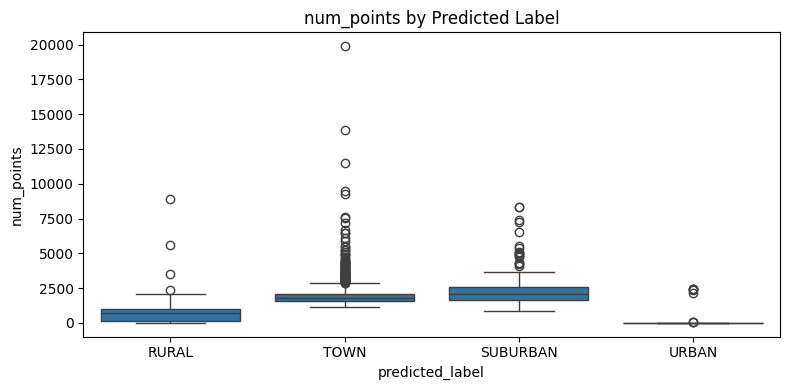

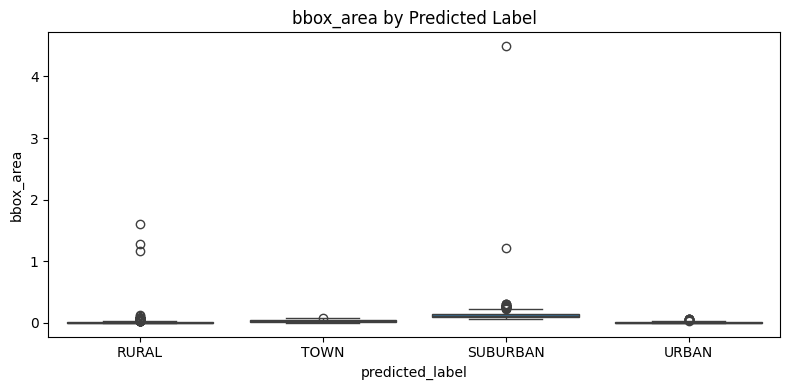

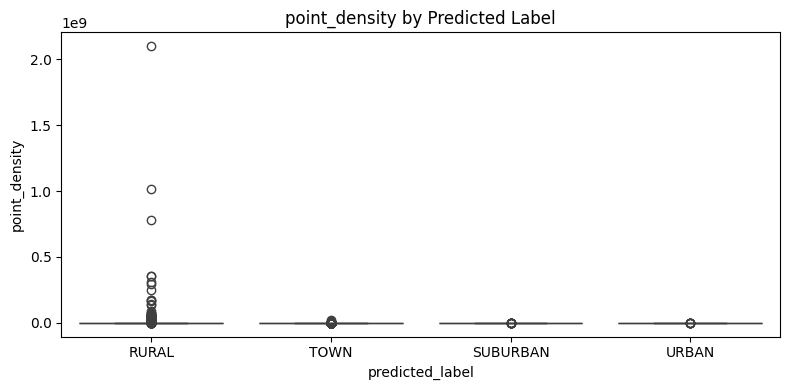

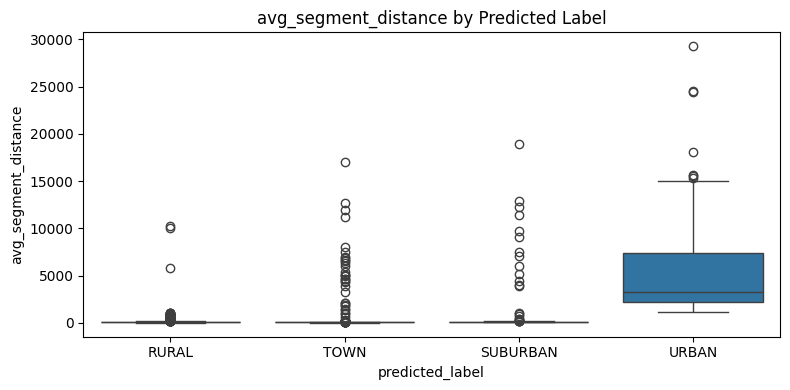

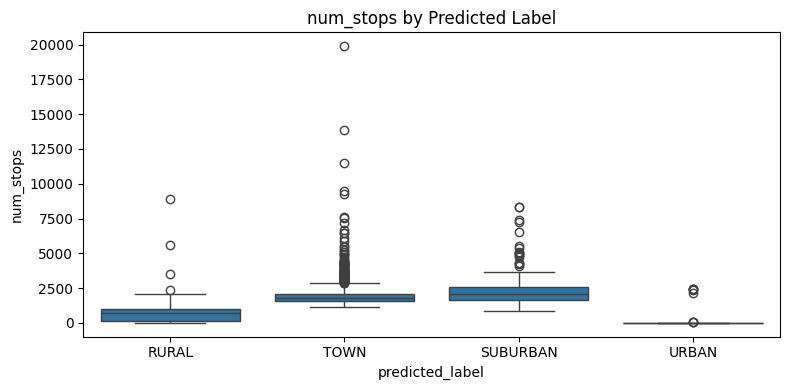

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

features_to_plot = ["num_points", "bbox_area", "point_density", "avg_segment_distance", "num_stops"]

for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=new_data, x="predicted_label", y=feature)
    plt.title(f"{feature} by Predicted Label")
    plt.tight_layout()
    plt.show()


In [4]:
df = pd.read_csv("new_tracking_predictions.csv")

for label in df["predicted_label"].unique():
    print(f"\n=== {label} ===")
    display(df[df["predicted_label"] == label].sample(3, random_state=42))



=== TOWN ===


,tracking_id,num_points,bbox_area,point_density,avg_segment_distance,num_stops,predicted_label
5505,72424,39,0.000011,3.151323e+06,37.680941,39,TOWN
2558,33632,16,0.000324,4.922733e+04,476.222370,16,TOWN
4472,67844,17,0.000009,1.706920e+06,42.222309,17,TOWN



=== URBAN ===


,tracking_id,num_points,bbox_area,point_density,avg_segment_distance,num_stops,predicted_label
3759,60578,41,5.715325e-06,6.105438e+06,15.903956,41,URBAN
6562,78964,5,4.872303e-09,4.975757e+06,5.316863,5,URBAN
786,4928,5,3.474821e-08,4.832093e+06,8.089273,5,URBAN



=== SUBURBAN ===


,tracking_id,num_points,bbox_area,point_density,avg_segment_distance,num_stops,predicted_label
4747,68819,408,0.001829,222994.095112,64.522457,408,SUBURBAN
178,1057,1633,0.005988,272662.350607,58.053227,1633,SUBURBAN
6302,76840,175,0.000507,344355.496935,51.088102,175,SUBURBAN



=== RURAL ===


,tracking_id,num_points,bbox_area,point_density,avg_segment_distance,num_stops,predicted_label
765,4682,22,3.779299,5.821183,13089.119702,22,RURAL
859,5543,2,3.766779,0.530958,273408.805408,2,RURAL
3525,53009,3,4.989394,0.601275,372821.349889,3,RURAL


/tmp/ipykernel_15166/1361592107.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=2, random_state=42))["tracking_id"]


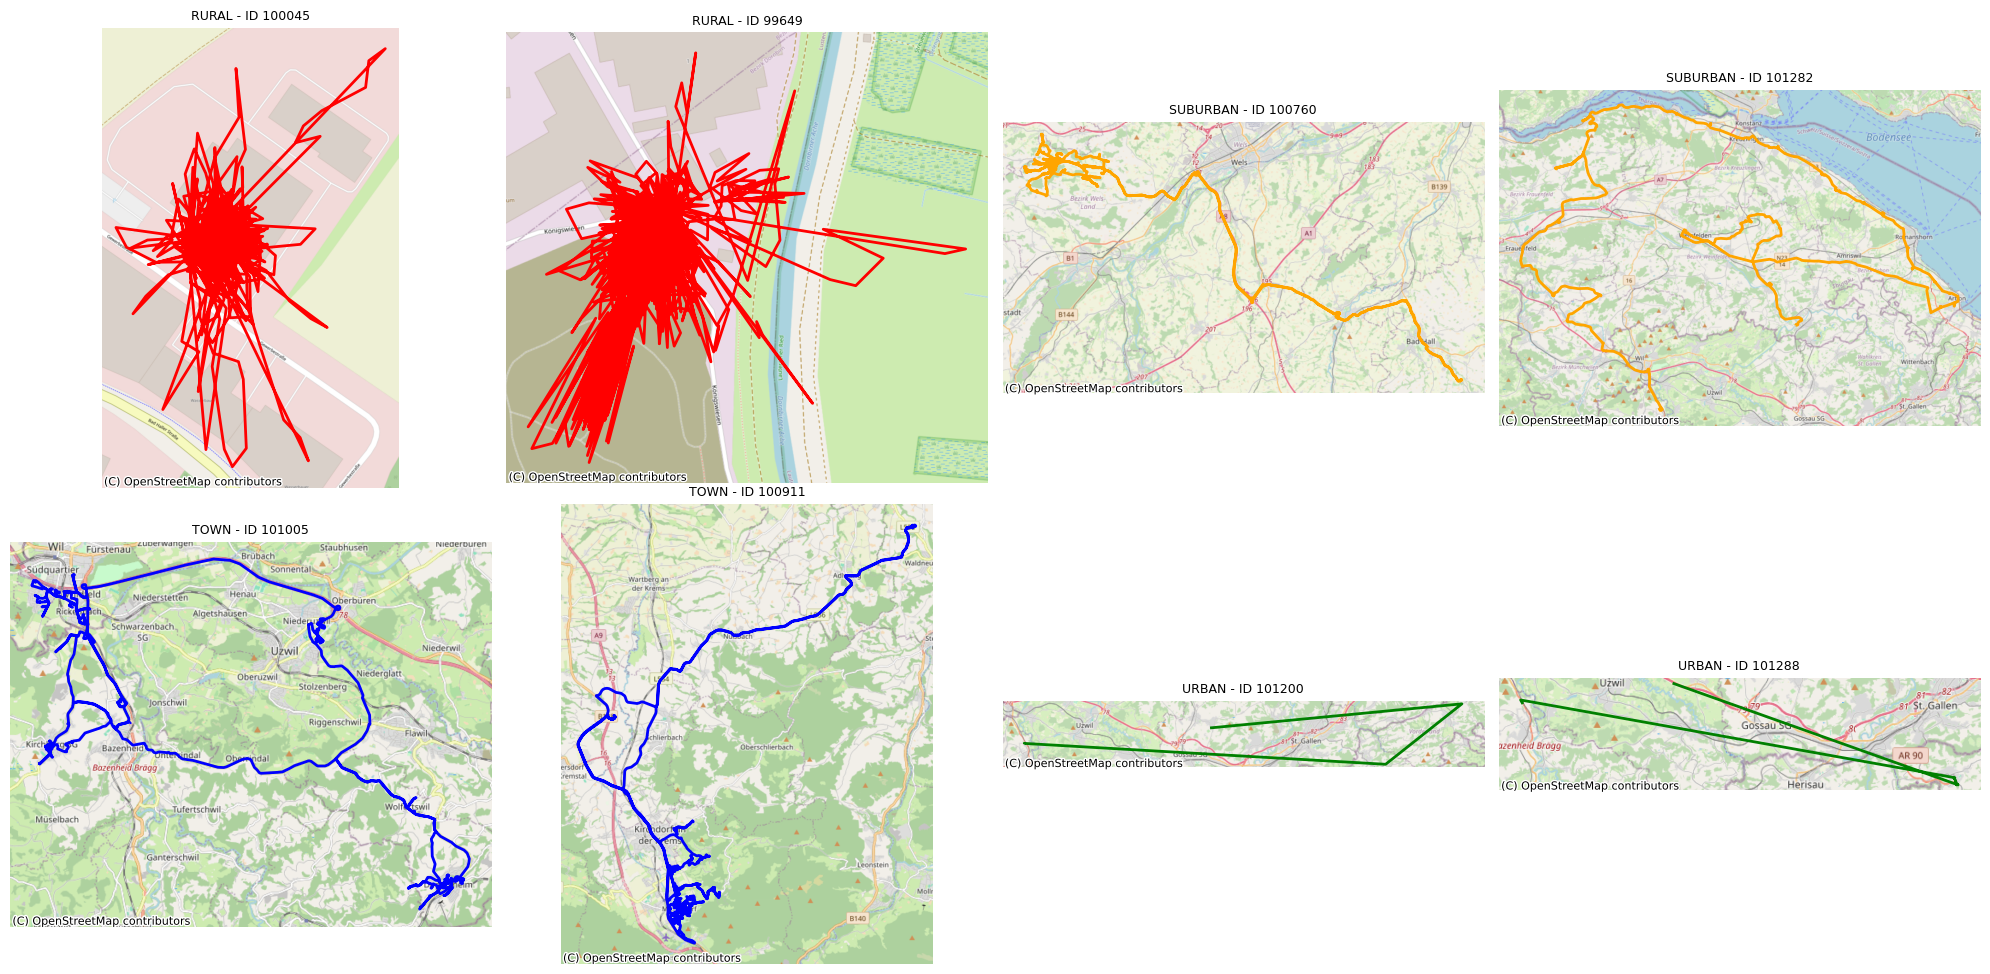

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import LineString

predicted_df = pd.read_csv("new_tracking_predictions.csv")
waypoints_df = pd.read_parquet("../2_Feature_Extraction_test_all_data/data/all_gps_data_without_sorting.parquet")

sampled_ids = (
    predicted_df.groupby("predicted_label")
    .apply(lambda x: x.sample(n=2, random_state=42))["tracking_id"]
    .explode()
    .tolist()
)

sampled_routes = waypoints_df[waypoints_df["id_tracking"].isin(sampled_ids)]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

color_map = {
    "RURAL": "red",
    "SUBURBAN": "orange",
    "TOWN": "blue",
    "URBAN": "green"
}

for i, tracking_id in enumerate(sampled_ids):
    ax = axes[i]
    route = sampled_routes[sampled_routes["id_tracking"] == tracking_id].sort_values("sequence")
    coords = list(zip(route["longitude"], route["latitude"]))
    label = predicted_df[predicted_df["tracking_id"] == tracking_id]["predicted_label"].values[0]

    if len(coords) < 2:
        continue

    line = LineString(coords)
    gdf = gpd.GeoDataFrame(index=[0], geometry=[line], crs="EPSG:4326").to_crs(epsg=3857)

    gdf.plot(ax=ax, color=color_map.get(label, "gray"), linewidth=2)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    ax.set_title(f"{label} - ID {tracking_id}", fontsize=9)
    ax.set_axis_off()

for j in range(len(sampled_ids), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# plt.savefig("Figures/predicted_tracking_routes_mapgrid.png", dpi=300)
plt.show()
